In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [6]:
class PixelDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

In [8]:
Dataset_features = np.load("/home/uas-dtu/Motor_alertness_final/stacked_features.npy")
Dataset_labels   = np.load("/home/uas-dtu/Motor_alertness_final/labels.npy")

Dataset_labels = Dataset_labels.reshape(-1)
train_features, test_features, train_labels, test_labels = train_test_split(Dataset_features, Dataset_labels, test_size=0.2, random_state=42,stratify=Dataset_labels)

test_labels=test_labels.reshape(-1,1)
train_labels=train_labels.reshape(-1,1)

train_dataset = PixelDataset(train_features, train_labels)
test_dataset  = PixelDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [18]:
class PixelClassifier(nn.Module):
    def __init__(self, input_size=4, hidden_size=512, num_layers=2, fc_hidden=256):
        super(PixelClassifier, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.2)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x,return_features=False):
        lstm_out, (h_n, _) = self.lstm(x)
        last_hidden = h_n[-1]  # (batch, hidden_size)
        out = self.fc(last_hidden)  # (batch, 1)
        
        if return_features:
            return last_hidden,out
        else:
            return out   
        


In [26]:
      
from torch.optim.lr_scheduler import CosineAnnealingLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PixelClassifier().to(device)


if torch.is_tensor(train_labels):
    train_labels_np = train_labels.cpu().numpy()
else:
    train_labels_np = train_labels

count_neg = np.sum(train_labels_np == 0)
count_pos = np.sum(train_labels_np == 1)


if count_pos > 0:
    pos_weight_value = count_neg / count_pos
else:
    pos_weight_value = 1.0 

pos_weight_tensor = torch.tensor([pos_weight_value], device=device)

print(f"Class Imbalance Detected: {count_neg} negatives, {count_pos} positives.")
print(f"Calculated positive weight for loss function: {pos_weight_tensor.item():.2f}")
# pos_weight=pos_weight_tensor
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)


epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)


best_val_loss = float('inf') # Initialize with a very large number
checkpoint_path = 'best_model_checkpoint.pth'


for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # LOGIC TO SAVE THE BEST CHECKPOINT 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"  -> New best validation loss: {best_val_loss:.4f}. Saving checkpoint...")
        
        # Save the model state
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
            }, checkpoint_path)

Class Imbalance Detected: 13965 negatives, 550 positives.
Calculated positive weight for loss function: 25.39
Epoch [1/100] Train Loss: 0.9770 | Val Loss: 1.1301
  -> New best validation loss: 1.1301. Saving checkpoint...
Epoch [2/100] Train Loss: 0.9008 | Val Loss: 0.7684
  -> New best validation loss: 0.7684. Saving checkpoint...
Epoch [3/100] Train Loss: 0.7747 | Val Loss: 0.6422
  -> New best validation loss: 0.6422. Saving checkpoint...
Epoch [4/100] Train Loss: 0.7114 | Val Loss: 0.5693
  -> New best validation loss: 0.5693. Saving checkpoint...
Epoch [5/100] Train Loss: 0.6635 | Val Loss: 0.4622
  -> New best validation loss: 0.4622. Saving checkpoint...
Epoch [6/100] Train Loss: 0.5751 | Val Loss: 0.7973
Epoch [7/100] Train Loss: 0.5080 | Val Loss: 0.3503
  -> New best validation loss: 0.3503. Saving checkpoint...
Epoch [8/100] Train Loss: 0.6217 | Val Loss: 0.4287
Epoch [9/100] Train Loss: 0.4399 | Val Loss: 0.3464
  -> New best validation loss: 0.3464. Saving checkpoint...
Ep

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='viridis')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Not Twitch', 'Twitch'])
    plt.title('t-SNE visualization of model predictions')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

def evaluate_from_checkpoint(model, checkpoint_path, test_loader, device):
    if not os.path.exists(checkpoint_path):
        print(f"Error: Checkpoint file not found at '{checkpoint_path}'")
        return

    print(f"Loading model for evaluation from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    all_preds, all_labels, all_features = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            features, logits = model(x, return_features=True) 
            preds = torch.round(torch.sigmoid(logits))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_features.append(features.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)

    # Print the evaluation results
    print("\n--- Evaluation Report ---")
    print(classification_report(all_labels, all_preds, target_names=['Not Twitch (0)', 'Twitch (1)'], digits=4))
    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    plot_tsne(all_features, all_labels)
    print("-------------------------\n")


Evaluating train accuracy
Loading model for evaluation from: best_model_checkpoint.pth

--- Evaluation Report ---
                precision    recall  f1-score   support

Not Twitch (0)     0.9998    0.9951    0.9975     13965
    Twitch (1)     0.8894    0.9945    0.9391       550

      accuracy                         0.9951     14515
     macro avg     0.9446    0.9948    0.9683     14515
  weighted avg     0.9956    0.9951    0.9952     14515


Confusion Matrix:
[[13897    68]
 [    3   547]]
Accuracy: 0.9951 | Precision: 0.8894 | Recall: 0.9945 | F1: 0.9391
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14515 samples in 0.002s...


/home/uas-dtu/anaconda3/envs/alltracker/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 14515 samples in 1.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14515
[t-SNE] Computed conditional probabilities for sample 2000 / 14515
[t-SNE] Computed conditional probabilities for sample 3000 / 14515
[t-SNE] Computed conditional probabilities for sample 4000 / 14515
[t-SNE] Computed conditional probabilities for sample 5000 / 14515
[t-SNE] Computed conditional probabilities for sample 6000 / 14515
[t-SNE] Computed conditional probabilities for sample 7000 / 14515
[t-SNE] Computed conditional probabilities for sample 8000 / 14515
[t-SNE] Computed conditional probabilities for sample 9000 / 14515
[t-SNE] Computed conditional probabilities for sample 10000 / 14515
[t-SNE] Computed conditional probabilities for sample 11000 / 14515
[t-SNE] Computed conditional probabilities for sample 12000 / 14515
[t-SNE] Computed conditional probabilities for sample 13000 / 14515
[t-SNE] Computed conditional probabilities for sample 14000 / 14515

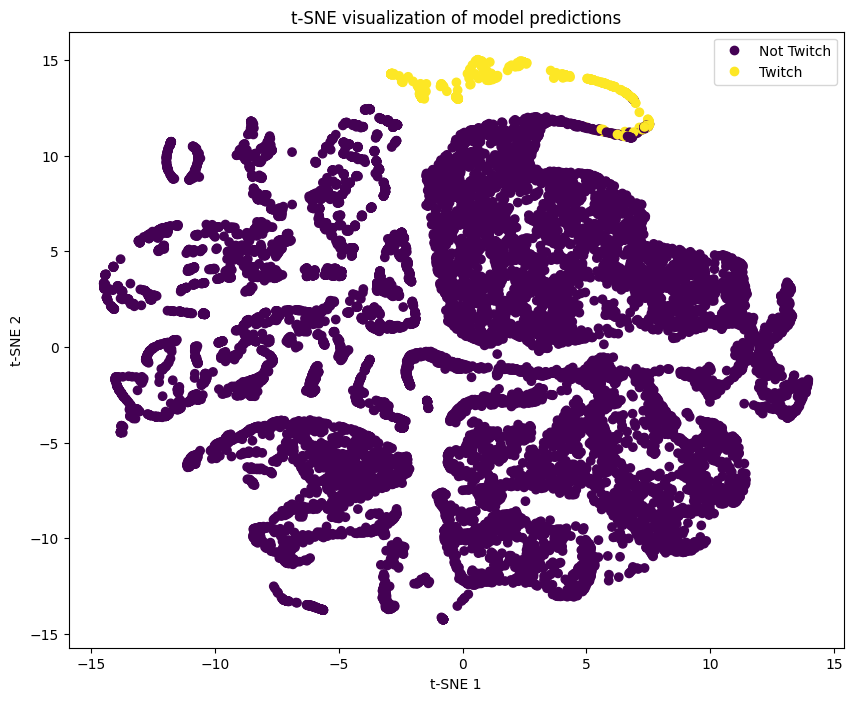

-------------------------

Evaluating test accuracy
Loading model for evaluation from: best_model_checkpoint.pth

--- Evaluation Report ---
                precision    recall  f1-score   support

Not Twitch (0)     0.9997    0.9951    0.9974      3492
    Twitch (1)     0.8889    0.9927    0.9379       137

      accuracy                         0.9950      3629
     macro avg     0.9443    0.9939    0.9677      3629
  weighted avg     0.9955    0.9950    0.9952      3629


Confusion Matrix:
[[3475   17]
 [   1  136]]
Accuracy: 0.9950 | Precision: 0.8889 | Recall: 0.9927 | F1: 0.9379
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3629 samples in 0.001s...
[t-SNE] Computed neighbors for 3629 samples in 0.145s...


/home/uas-dtu/anaconda3/envs/alltracker/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 3629
[t-SNE] Computed conditional probabilities for sample 2000 / 3629
[t-SNE] Computed conditional probabilities for sample 3000 / 3629
[t-SNE] Computed conditional probabilities for sample 3629 / 3629
[t-SNE] Mean sigma: 0.370670
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.443439
[t-SNE] KL divergence after 300 iterations: 1.416889


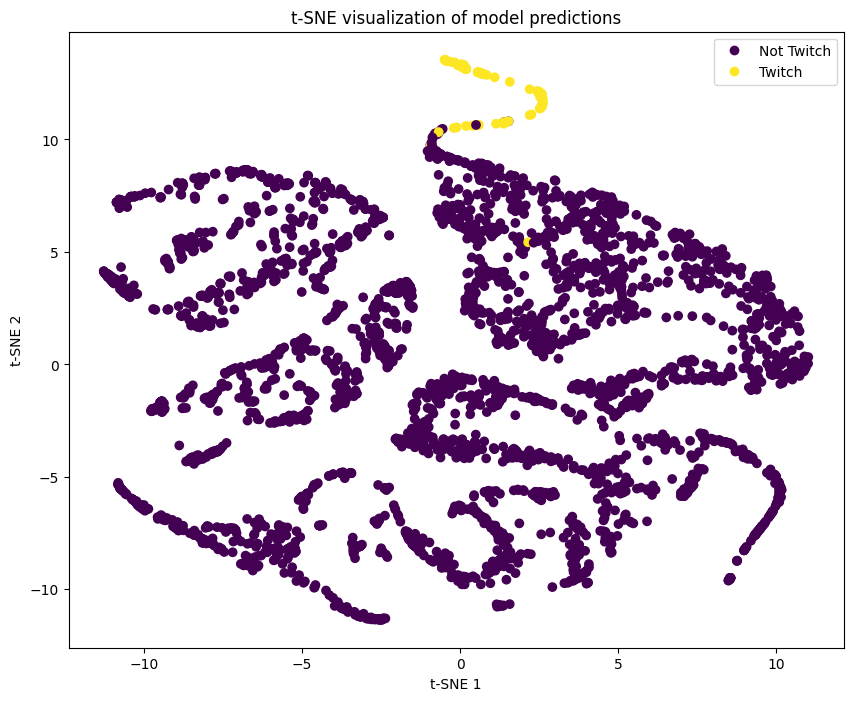

-------------------------



In [28]:
if __name__ == "__main__":

    CONFIG = {
        "checkpoint_path": "best_model_checkpoint.pth",
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = PixelClassifier()
    
    if not os.path.exists(CONFIG["checkpoint_path"]):
        print(f"Checkpoint not found")
        
    print("Evaluating train accuracy")

    evaluate_from_checkpoint(
        model=model,
        checkpoint_path=CONFIG["checkpoint_path"],
        test_loader=train_loader,
        device=device
    )
    print("Evaluating test accuracy")
    
    evaluate_from_checkpoint(
        model=model,
        checkpoint_path=CONFIG["checkpoint_path"],
        test_loader=test_loader,
        device=device
    )